In [1]:
import yaml

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

dict_names = [
    "nn",
    "gnn",
    "gnn_transformer",
    "coevosg",
]

full_names = [
    "Feed-Forward Neural Network",
    "Graph Neural Network",
    "Graph Neural Network with Transformer",
    "CoevoSG",
]

def read_data(file_path):
    with open(file_path, "r") as f:
        data = yaml.safe_load(f)
    return data

sns.set(style="whitegrid")
def plot_density(data):
    results = [get_data(data, key) for key in dict_names]
    plt.figure(figsize=(10, 6))
    for result, title in zip(results, full_names):
        sns.kdeplot(data=result, fill=True, label=title)
    plt.title("Comparison of reward distributions")
    plt.xlabel("Reward")
    plt.ylabel("Density")
    plt.legend()
    #plt.xlim(-1, 1)
    #plt.ylim(0, 5)
    plt.grid()
    plt.show()
    
def get_data(results, key):
    out = []
    for k in results:
        if k.startswith(f"{key}/") and k.endswith("/raw"):
            out.extend(results[k])
    return out

def get_data_specific(results, key1, key2):
    out = []
    for k in results:
        if k.startswith(f"{key1}/{key2}/") and k.endswith("/raw"):
            out.extend(results[k])
    return out

def compare_models(results, model1, model2, print_results=False):
    data1 = get_data(results, model1)
    data2 = get_data(results, model2)
    
    if len(data1) != len(data2):
        raise ValueError("Data lengths do not match for comparison.")
    
    stat, p_value = wilcoxon(np.array(data1) - np.array(data2), alternative="greater")
    if print_results:
        print(f"Wilcoxon test between {model1} and {model2}: statistic={stat:.3f}, p-value={p_value:.3f}")
        
        if p_value < 0.05:
            print(f"Result: {model1} is statistically significantly better than {model2}.")
        else:
            print(f"Result: {model1} is not statistically significantly better than {model2}.")
        
    return p_value

def holm_bonferroni_correction(p_values):
    corrected = multipletests(p_values, method='holm')
    return corrected[1]  # Return the corrected p-values
    
def compare_many_models(results, compared_model, print_results=False):
    models_to_compare = [
        "nn", "gnn", "gnn_transformer", "coevosg"
    ]
    models_without_the_model = [model for model in models_to_compare if model != compared_model]
    p_values = [compare_models(results, compared_model, model, print_results=False) for model in models_without_the_model]

    corrected_p_values = holm_bonferroni_correction(p_values) 
    output = {}
    if print_results:
        print(f"{compared_model} vs others p-values:")
    for model, p_value, org_p_value in zip(models_without_the_model, corrected_p_values, p_values):
        output[model] = {"p_value": p_value, "org_p_value": org_p_value}
        if print_results:
            print(f"{model}: {p_value:.5f}({org_p_value:.5f}) - {'Significantly' if p_value < 0.05 else 'Not significantly'} better")
    return output

def compare_all_models(results, print_results=False):
    all_results = {}
    for model in dict_names:
        all_results[model] = compare_many_models(results, model, print_results=False)
    # print results as table
    if print_results:
        print(f"{'Model':<30} {'Compared Model':<30} {'Corrected p-value':<20} {'Original p-value':<20} {'Significance':<15}")
        for model in dict_names:
            for compared_model, values in all_results[model].items():
                significance = 'Significantly' if values['p_value'] < 0.05 else 'Not significantly'
                print(f"{model:<30} {compared_model:<30} {values['p_value']:<20.5f} {values['org_p_value']:<20.5f} {significance:<15}")
    return all_results

def get_summarized_results_for_all_models(data, print_results=False):
    out = {}
    for model in dict_names:
        model_data = get_data(data, model)
        mean = np.mean(model_data)
        std = np.std(model_data)
        out[model] = {"mean": mean, "std": std, "n": len(model_data)}
    # print results as table
    if print_results:
        print(f"{'Model':<30} {'Mean':<10} {'Std':<10} {'N':<10}")
        for model in dict_names:
            print(f"{model:<30} {out[model]['mean']:<10.4f} {out[model]['std']:<10.4f} {out[model]['n']:<10}")
    return out

In [3]:
poachers_10 = read_data("results2/test_poachers_10_20_41.yaml")
_ = get_summarized_results_for_all_models(poachers_10, print_results=True)
_ = compare_all_models(poachers_10, print_results=True)

Model                          Mean       Std        N         
nn                             -0.8807    6.5665     600       
gnn                            0.6895     6.2828     600       
gnn_transformer                1.7032     6.0983     600       
coevosg                        -0.3665    6.4737     600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            0.31938              0.10646              Not significantly
nn                             gnn_transformer                1.00000              0.99032              Not significantly
nn                             coevosg                        1.00000              0.99996              Not significantly
gnn                            nn                             1.00000              0.89354              Not significantly
gnn                            gnn_transformer                1.00000   

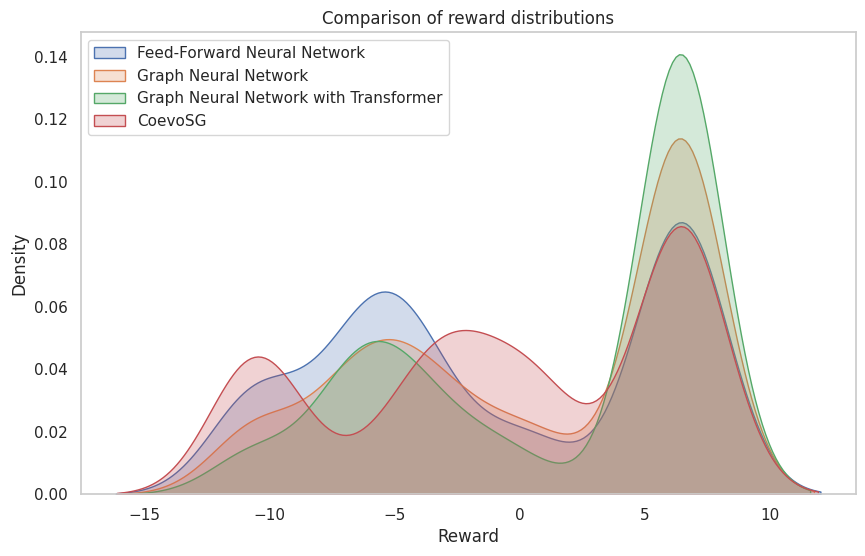

In [4]:
plot_density(poachers_10)

In [24]:
flipit_25 = read_data("results/test_flipit_25_20_41.yaml")
_ = get_summarized_results_for_all_models(flipit_25, print_results=True)
_ = compare_all_models(flipit_25, print_results=True)

Model                          Mean       Std        N         
nn                             185.1861   47.4182    600       
gnn                            178.3127   38.4722    600       
gnn_transformer                208.6373   25.0413    600       
coevosg                        182.1413   45.9021    600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            0.00000              0.00000              Significantly  
nn                             gnn_transformer                1.00000              1.00000              Not significantly
nn                             coevosg                        0.00000              0.00000              Significantly  
gnn                            nn                             1.00000              1.00000              Not significantly
gnn                            gnn_transformer                1.00000       

In [25]:
flipit_30 = read_data("results/test_flipit_30_30_41.yaml")
_ = get_summarized_results_for_all_models(flipit_30, print_results=True)
_ = compare_all_models(flipit_30, print_results=True)

Model                          Mean       Std        N         
nn                             476.0147   31.4039    600       
gnn                            404.0197   110.6012   600       
gnn_transformer                481.8924   37.8399    600       
coevosg                        412.2561   98.0294    600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            0.00000              0.00000              Significantly  
nn                             gnn_transformer                1.00000              1.00000              Not significantly
nn                             coevosg                        0.00000              0.00000              Significantly  
gnn                            nn                             1.00000              1.00000              Not significantly
gnn                            gnn_transformer                1.00000       

In [26]:
flipit_60 = read_data("results/test_flipit_60_40_41.yaml")
_ = get_summarized_results_for_all_models(flipit_60, print_results=True)
_ = compare_all_models(flipit_60, print_results=True)

Model                          Mean       Std        N         
nn                             1046.2489  79.9182    600       
gnn                            977.3657   165.8022   600       
gnn_transformer                1050.7170  78.7355    600       
coevosg                        984.0320   159.5197   600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            0.00000              0.00000              Significantly  
nn                             gnn_transformer                0.00032              0.00032              Significantly  
nn                             coevosg                        0.00000              0.00000              Significantly  
gnn                            nn                             1.00000              1.00000              Not significantly
gnn                            gnn_transformer                1.00000         

# Poachers

In [27]:
poachers_5 = read_data("results/test_poachers_5_15_41.yaml")
_ = get_summarized_results_for_all_models(poachers_5, print_results=True)
_ = compare_all_models(poachers_5, print_results=True)

Model                          Mean       Std        N         
nn                             -0.5175    1.3327     600       
gnn                            -1.3909    2.4262     600       
gnn_transformer                1.0115     0.5474     600       
coevosg                        0.4478     1.5515     600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            0.00000              0.00000              Significantly  
nn                             gnn_transformer                1.00000              1.00000              Not significantly
nn                             coevosg                        1.00000              1.00000              Not significantly
gnn                            nn                             1.00000              1.00000              Not significantly
gnn                            gnn_transformer                1.00000     

In [28]:
poachers_10 = read_data("results/test_poachers_10_20_41.yaml")
_ = get_summarized_results_for_all_models(poachers_10, print_results=True)
_ = compare_all_models(poachers_10, print_results=True)

Model                          Mean       Std        N         
nn                             -0.6250    1.5313     600       
gnn                            -1.9624    2.3793     600       
gnn_transformer                -1.3111    1.5493     600       
coevosg                        -1.1984    1.8661     600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            0.00000              0.00000              Significantly  
nn                             gnn_transformer                0.00000              0.00000              Significantly  
nn                             coevosg                        0.00000              0.00000              Significantly  
gnn                            nn                             1.00000              1.00000              Not significantly
gnn                            gnn_transformer                1.00000         

In [29]:
poachers_20 = read_data("results/test_poachers_20_40_41.yaml")
_ = get_summarized_results_for_all_models(poachers_20, print_results=True)
_ = compare_all_models(poachers_20, print_results=True)

Model                          Mean       Std        N         
nn                             -2.2267    4.1336     600       
gnn                            -2.0411    4.1646     600       
gnn_transformer                -2.3006    4.4955     600       
coevosg                        -3.8452    5.4275     600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            0.99383              0.49691              Not significantly
nn                             gnn_transformer                0.99383              0.84994              Not significantly
nn                             coevosg                        0.00000              0.00000              Significantly  
gnn                            nn                             0.50309              0.50309              Not significantly
gnn                            gnn_transformer                0.39862     

In [30]:
poachers_30 = read_data("results/test_poachers_30_70_41.yaml")
_ = get_summarized_results_for_all_models(poachers_30, print_results=True)
_ = compare_all_models(poachers_30, print_results=True)

Model                          Mean       Std        N         
nn                             -3.2520    5.1857     600       
gnn                            -4.5637    6.3635     600       
gnn_transformer                -4.9719    6.3276     600       
coevosg                        -4.9864    6.4590     600       
Model                          Compared Model                 Corrected p-value    Original p-value     Significance   
nn                             gnn                            0.00003              0.00003              Significantly  
nn                             gnn_transformer                0.00000              0.00000              Significantly  
nn                             coevosg                        0.00000              0.00000              Significantly  
gnn                            nn                             0.99997              0.99997              Not significantly
gnn                            gnn_transformer                0.00870         